# This notebook demonstrates the use of a DEMV pre-processing algorithm for bias mitigation

_Debiaser for Multiple Variables (DEMV)_ is a pre-processing algorithm to mitigate the bias of binary and multi-class (i.e., datasets where the label has more than 2 values) with any number of sensitive variables [1].

 [1] G. d'Aloisio, A. D'Angelo, A. Di Marco, e G. Stilo, «Debiaser for Multiple Variables to enhance fairness in classification tasks», Information Processing & Management, vol. 60, mar. 2023, doi: 10.1016/j.ipm.2022.103226.

### Note

In this example, we use DEMV on a binary label dataset, but DEMV is designed to work also on MultiClass datasets.

In [8]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.demv import DEMV
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from common_utils import compute_metrics

## Load dataset and set options

In [9]:
## import dataset
dataset_used = "adult" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2


if dataset_used == "adult":
#     dataset_orig = AdultDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
    
elif dataset_used == "german":
#     dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_compas(['race'])

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

#random seed for calibrated equal odds prediction
np.random.seed(1)

#### Split into train, and test

In [10]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#### Clean up training data

In [11]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


#### Metric for original training data

In [12]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
print("Disparate Impact between unprivileged and privileged groups = %f" % metric_orig_train.disparate_impact())
print("Statistical Parity difference between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.190244
Disparate Impact between unprivileged and privileged groups = 0.367778
Statistical Parity difference between unprivileged and privileged groups = -0.190244


#### Train with and transform the original training data

In [13]:
demv = DEMV()

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
newdata = demv.fit_transform(dataset_orig_train)

In [16]:
print( newdata )

               instance weights features                                      \
                                         protected attribute                   
                                    race                 sex Age (decade)=10   
instance names                                                                 
24378                       1.0      1.0                 0.0             0.0   
45162                       1.0      1.0                 1.0             0.0   
9877                        1.0      1.0                 0.0             0.0   
31039                       1.0      0.0                 1.0             0.0   
28752                       1.0      1.0                 1.0             0.0   
...                         ...      ...                 ...             ...   
32861                       1.0      1.0                 1.0             0.0   
6600                        1.0      1.0                 1.0             0.0   
29327                       1.0      1.0

#### Metric with the transformed training data

In [17]:
metric_transf_train = BinaryLabelDatasetMetric(newdata, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())
print("Disparate Impact between unprivileged and privileged groups = %f" % metric_transf_train.disparate_impact())
print("Statistical Parity difference between unprivileged and privileged groups = %f" % metric_transf_train.statistical_parity_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.036211
Disparate Impact between unprivileged and privileged groups = 0.858829
Statistical Parity difference between unprivileged and privileged groups = -0.036211


## Plot the balancing of the groups

In [18]:
import seaborn as sns
def plot_groups_disparity(disparities):
    fig, ax = plt.subplots()
    for d in disparities:
        sns.lineplot(data=d)
    plt.axhline(y=1, linewidth=2)
    ax.set_ylabel('Group disparity')
    return ax

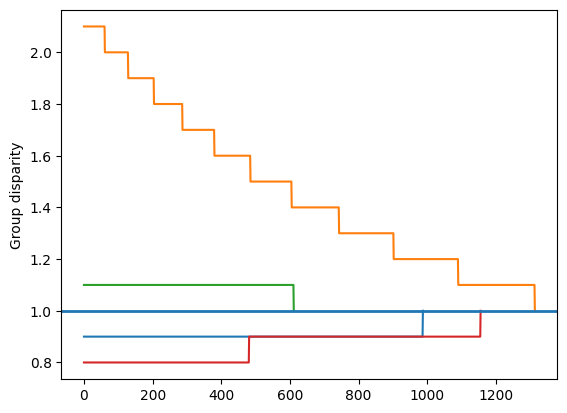

In [19]:
plot_groups_disparity(demv.get_disparities()[0])
plt.show()


Eventually, $W_{exp}/W_{obs}$ of all the groups converges to one. This means that all the groups are totally balanced
